# Individual Waves from All Time Series Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import signal
from scipy import interpolate
from scipy import optimize
from scipy import io
import cftime
import netCDF4 as nc
import pickle
import glob
import scipy.stats as st
from PyAstronomy import pyaC
import cmocean
# import cftime
%matplotlib widget

In [ ]:
# # Test function to remove waves that are too big and not physical
# def waveHeightDist(mission_nc):
#     # Load in Mission Data
#     mission_dataset = nc.Dataset(mission_nc, mode='r')

#     # Get list of all microSWIFTs on the mission
#     microSWIFTs_on_mission = list(mission_dataset.groups.keys())

#     # Iniialize the arrays to store the wave height and locations in 
#     wave_heights = []
#     wave_x_locs = []
#     wave_y_locs = []

#     # For Each microSWIFT sea surface elevation, find all zero crossings of the sea surface elevation
#     for microSWIFT in microSWIFTs_on_mission:
#         eta = mission_dataset[microSWIFT]['eta'][:] 
#         x = mission_dataset[microSWIFT]['xFRF'][:]
#         y = mission_dataset[microSWIFT]['yFRF'][:]
#         time = mission_dataset['time'][:]
#         cross_time, cross_ind = pyaC.zerocross1d(time, eta, getIndices=True)

#         # Get every other index so we have zero crossings in the same direction 
#         wave_inds = cross_ind[::2]

#         # Compute Wave Height from each set of indices
#         for n in np.arange(np.size(wave_inds)-1):
#             # Get all elevation heights in between each zero crossing index
#             eta_in_wave = eta[wave_inds[n]:wave_inds[n+1]]
#             x_in_wave = x[wave_inds[n]:wave_inds[n+1]]
#             y_in_wave = y[wave_inds[n]:wave_inds[n+1]]

#             # Check if there are any values otherwise skip
#             if np.size(eta_in_wave) > 0: 
#                 # Add the compute wave height
#                 wave_height = np.max(eta_in_wave)- np.min(eta_in_wave)
#                 if np.isnan(wave_height)==False and wave_height <= 8:
#                     wave_heights.append(wave_height)
#                     # Add the computed average location of the wave
#                     wave_x_locs.append(np.mean(x_in_wave))
#                     wave_y_locs.append(np.mean(y_in_wave))
#             else: 
#                 continue
#     mission_dataset.close()

#     return wave_heights, wave_x_locs, wave_y_locs

: 

: 

In [ ]:
# Compute Distribution of Individual waves from all microSWIFTs using zero crossing algorithm 
def waveHeightDist(mission_nc):
    # Load in Mission Data
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    # Get list of all microSWIFTs on the mission
    microSWIFTs_on_mission = list(mission_dataset.groups.keys())

    # Iniialize the arrays to store the wave height and locations in 
    wave_heights = []
    wave_x_locs = []
    wave_y_locs = []

    # For Each microSWIFT sea surface elevation, find all zero crossings of the sea surface elevation
    for microSWIFT in microSWIFTs_on_mission:
        eta = mission_dataset[microSWIFT]['eta'][:] 
        x = mission_dataset[microSWIFT]['xFRF'][:]
        y = mission_dataset[microSWIFT]['yFRF'][:]
        time = mission_dataset['time'][:]
        cross_time, cross_ind = pyaC.zerocross1d(time, eta, getIndices=True)

        # Get every other index so we have zero crossings in the same direction 
        wave_inds = cross_ind[::2]

        # Compute Wave Height from each set of indices
        for n in np.arange(np.size(wave_inds)-1):
            # Get all elevation heights in between each zero crossing index
            eta_in_wave = eta[wave_inds[n]:wave_inds[n+1]]
            x_in_wave = x[wave_inds[n]:wave_inds[n+1]]
            y_in_wave = y[wave_inds[n]:wave_inds[n+1]]

            # Check if there are any values otherwise skip
            if np.size(eta_in_wave) > 0: 
                # Add the compute wave height
                wave_heights.append(np.max(eta_in_wave)- np.min(eta_in_wave))
                
                # Add the computed average location of the wave
                wave_x_locs.append(np.mean(x_in_wave))
                wave_y_locs.append(np.mean(y_in_wave))
            else: 
                continue
    mission_dataset.close()

    return wave_heights, wave_x_locs, wave_y_locs

def interpDepth(x,y):
    # Load in bathymetry Data and find location of each 
    bathy_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc')
    elevation_dem = bathy_data['elevation'][0,:,:]
    bathy_xFRF = bathy_data['xFRF'][:]
    bathy_yFRF = bathy_data['yFRF'][:]
    bathy_f = interpolate.interp2d(bathy_xFRF, bathy_yFRF, elevation_dem)

    # Depth of each wave
    depth = []
    for n in np.arange(len(x)):
        depth.append(np.squeeze(bathy_f(x[n], y[n])).item())
    return depth 

def computeSigWaveHeight(wave_heights):
    # Sort wave heights
    wave_height_sort = np.sort(wave_heights)

    # Get Top 1/3rd of wave heights
    top_third_waves = wave_height_sort[-(len(wave_heights)//3):]

    # Average Top 1/3rd of wave heights
    Hs = np.nanmean(top_third_waves)

    return Hs

def normalizeWaveHeight(wave_height, wave_depth):
    wave_height_norm = []
    for n in np.arange(len(wave_height)):
        wave_height_norm.append(wave_height[n]/np.abs(wave_depth[n]))

    return wave_height_norm

def normalizeCrossShoreDist(wave_x_locs, Hs):
    # Find cross shore location of Depth where surfzone is expected to start
    gamma = 0.5
    depth_surf_zone = Hs/gamma
    bathy_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc')
    elevation_dem = bathy_data['elevation'][0,:,:]
    bathy_xFRF = bathy_data['xFRF'][:]
    along_shore_avg_depth = np.mean(elevation_dem, axis=0)
    surf_zone_width = np.interp(depth_surf_zone, along_shore_avg_depth, bathy_xFRF)
    bathy_data.close()

    wave_x_loc_norm = []
    for n in np.arange(len(wave_x_locs)):
        wave_x_loc_norm.append(wave_x_locs[n]/surf_zone_width)

    return wave_x_loc_norm 

def processMissionWaves(mission_nc):
    print(mission_nc)
    # Get Distribution of Wave Heights and Locations
    wave_heights, wave_x_locs, wave_y_locs = waveHeightDist(mission_nc)

    # Compute Depth from each location
    wave_depth = interpDepth(wave_x_locs, wave_y_locs)

    # Compute Significant Wave Height
    Hs = computeSigWaveHeight(wave_heights)

    # Normalize Wave Heights
    wave_height_norm = normalizeWaveHeight(wave_heights, wave_depth)

    # Normalize Cross Shore Location
    wave_x_locs_norm = normalizeCrossShoreDist(wave_x_locs, Hs)

    # Mission Time 
    mission_dataset = nc.Dataset(mission_nc, mode='r')
    median_time = np.median(mission_dataset['time'][:])
    mission_time = cftime.num2pydate(median_time, units=mission_dataset['time'].units, calendar=mission_dataset['time'].calendar)
    mission_dataset.close()

    # # Plot Distribution of Wave Heights 
    # fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15,5), ncols=3)
    # # Plot Average Location of Each Wave on Bathymetry
    # bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
    # bathy_dataset = nc.Dataset(bathy_file)
    # # Create grid from coordinates
    # xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
    # bathy = bathy_dataset['elevation'][0,:,:]
    # im =ax1.contourf(xFRF_grid, yFRF_grid, bathy, cmap=cmocean.cm.deep_r)
    # cbar_bathy = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, location='top', orientation='horizontal')
    # cbar_bathy.ax.set_xlabel('Elevation, z [m]')
    # ax1.scatter(wave_x_locs, wave_y_locs, color='r', s=1, label='Average Location of Individual Waves')
    # ax1.legend()
    # ax1.set_xlabel('Cross Shore Location, x [m]')
    # ax1.set_ylabel('Along Shore Location, y [m]')

    # # Plot distribution of Wave Heights
    # ax2.hist(wave_heights, bins=50, density=True, label='Num Waves: {0:.0f}, Hs: {1:.2f} m'.format(len(wave_heights), Hs))
    # ax2.set_xlabel('Wave Height [m]')
    # ax2.set_ylabel('Probability Density [-]')
    # ax2.legend()

    # # Plot Normalized Wave Height versus cross shore location
    # ax3.scatter(wave_x_locs_norm, wave_height_norm)
    # ax3.hlines(y=np.nanmean(wave_height_norm), xmin=0, xmax=1, linewidth=2, color='r', label='Average H/d: {0:.2f}'.format(np.nanmean(wave_height_norm)))
    # ax3.vlines(x=1, ymin=0, ymax=7)
    # ax3.set_xlim(0, 2)
    # ax3.set_ylim(0, 7)
    # ax3.set_xlabel('Normalized Cross Shore Distance, x/$L_{sz}$ [-]')
    # ax3.set_ylabel('Depth Normalized Wave Height,H/d [-]')
    # ax3.legend()

    # # Save the Figure 
    # fig.savefig('./Figures/processedWaves_mission_{}.png'.format(mission_nc[-5:-3]))
    
    return wave_heights, wave_height_norm, Hs, wave_depth, wave_x_locs, wave_x_locs_norm, mission_time


: 

: 

In [ ]:
# Get Distribution of Wave Heights and Locations
mission_list = glob.glob('../microSWIFT_data/cleanedDataset/mission_*.nc')
wave_heights_all = []
wave_height_norm_all = []
Hs_all = []
wave_depth_all = []
wave_x_locs_all = []
wave_x_locs_norm_all = []
mission_time_all = []

for mission_nc in mission_list:
    wave_heights, wave_height_norm, Hs, wave_depth, wave_x_locs, wave_x_locs_norm, mission_time = processMissionWaves(mission_nc)

    # Append each variable to the overall datasets
    wave_heights_all.append(wave_heights)
    wave_height_norm_all.append(wave_height_norm)
    Hs_all.append(Hs)
    wave_depth_all.append(wave_depth)
    wave_x_locs_all.append(wave_x_locs)
    wave_x_locs_norm_all.append(wave_x_locs_norm)
    mission_time_all.append(mission_time)



../microSWIFT_data/cleanedDataset/mission_78.nc


/Users/ejrainville/Documents/DUNEXMainExp/.dunex-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


../microSWIFT_data/cleanedDataset/mission_29.nc
../microSWIFT_data/cleanedDataset/mission_9.nc
../microSWIFT_data/cleanedDataset/mission_39.nc
../microSWIFT_data/cleanedDataset/mission_68.nc
../microSWIFT_data/cleanedDataset/mission_48.nc
../microSWIFT_data/cleanedDataset/mission_19.nc
../microSWIFT_data/cleanedDataset/mission_58.nc
../microSWIFT_data/cleanedDataset/mission_18.nc
../microSWIFT_data/cleanedDataset/mission_59.nc
../microSWIFT_data/cleanedDataset/mission_79.nc
../microSWIFT_data/cleanedDataset/mission_28.nc
../microSWIFT_data/cleanedDataset/mission_8.nc
../microSWIFT_data/cleanedDataset/mission_38.nc
../microSWIFT_data/cleanedDataset/mission_69.nc
../microSWIFT_data/cleanedDataset/mission_3.nc
../microSWIFT_data/cleanedDataset/mission_81.nc
../microSWIFT_data/cleanedDataset/mission_72.nc
../microSWIFT_data/cleanedDataset/mission_23.nc
../microSWIFT_data/cleanedDataset/mission_17.nc
../microSWIFT_data/cleanedDataset/mission_46.nc
../microSWIFT_data/cleanedDataset/mission_5

/var/folders/yq/nm8v_c9d4_dbks_1kbmx542r0000gp/T/ipykernel_40353/3736491952.py:68: RuntimeWarning: Mean of empty slice
  Hs = np.nanmean(top_third_waves)


../microSWIFT_data/cleanedDataset/mission_13.nc
../microSWIFT_data/cleanedDataset/mission_27.nc
../microSWIFT_data/cleanedDataset/mission_76.nc
../microSWIFT_data/cleanedDataset/mission_66.nc
../microSWIFT_data/cleanedDataset/mission_37.nc
../microSWIFT_data/cleanedDataset/mission_52.nc
../microSWIFT_data/cleanedDataset/mission_43.nc
../microSWIFT_data/cleanedDataset/mission_12.nc
../microSWIFT_data/cleanedDataset/mission_26.nc
../microSWIFT_data/cleanedDataset/mission_77.nc
../microSWIFT_data/cleanedDataset/mission_67.nc
../microSWIFT_data/cleanedDataset/mission_36.nc
../microSWIFT_data/cleanedDataset/mission_2.nc
../microSWIFT_data/cleanedDataset/mission_80.nc
../microSWIFT_data/cleanedDataset/mission_73.nc
../microSWIFT_data/cleanedDataset/mission_22.nc
../microSWIFT_data/cleanedDataset/mission_16.nc
../microSWIFT_data/cleanedDataset/mission_32.nc
../microSWIFT_data/cleanedDataset/mission_63.nc
../microSWIFT_data/cleanedDataset/mission_11.nc
../microSWIFT_data/cleanedDataset/mission

: 

: 

In [ ]:
# Get Distribution of Wave Heights measured in the 4-5 meter depth range
mission_list = glob.glob('../microSWIFT_data/cleanedDataset/mission_*.nc')
wave_heights_45 = []
wave_depth_45 = []
mission_time_45 = []
mission_nums_45 = []

for mission_nc in mission_list:
    mission_wave_height = []
    wave_heights, wave_height_norm, Hs, wave_depth, wave_x_locs, wave_x_locs_norm, mission_time = processMissionWaves(mission_nc)

    # Find any waves in the 4-5 meter depth zone and compare them to the AWAC
    for n in np.arange(len(wave_depth)):
        if wave_depth[n] > -5 and wave_depth[n] < -4:
           mission_wave_height.append(wave_heights[n])

    # Append each variable to the overall datasets
    if len(mission_wave_height) > 0: 
        wave_heights_45.append(mission_wave_height)
        mission_time_45.append(mission_time)
        mission_nums_45.append(mission_nc)


../microSWIFT_data/cleanedDataset/mission_78.nc
../microSWIFT_data/cleanedDataset/mission_29.nc
../microSWIFT_data/cleanedDataset/mission_9.nc
../microSWIFT_data/cleanedDataset/mission_39.nc
../microSWIFT_data/cleanedDataset/mission_68.nc
../microSWIFT_data/cleanedDataset/mission_48.nc
../microSWIFT_data/cleanedDataset/mission_19.nc
../microSWIFT_data/cleanedDataset/mission_58.nc
../microSWIFT_data/cleanedDataset/mission_18.nc
../microSWIFT_data/cleanedDataset/mission_59.nc
../microSWIFT_data/cleanedDataset/mission_79.nc
../microSWIFT_data/cleanedDataset/mission_28.nc
../microSWIFT_data/cleanedDataset/mission_8.nc
../microSWIFT_data/cleanedDataset/mission_38.nc
../microSWIFT_data/cleanedDataset/mission_69.nc
../microSWIFT_data/cleanedDataset/mission_3.nc
../microSWIFT_data/cleanedDataset/mission_81.nc
../microSWIFT_data/cleanedDataset/mission_72.nc
../microSWIFT_data/cleanedDataset/mission_23.nc
../microSWIFT_data/cleanedDataset/mission_17.nc
../microSWIFT_data/cleanedDataset/mission_4

/var/folders/yq/nm8v_c9d4_dbks_1kbmx542r0000gp/T/ipykernel_40353/3736491952.py:68: RuntimeWarning: Mean of empty slice
  Hs = np.nanmean(top_third_waves)


../microSWIFT_data/cleanedDataset/mission_13.nc
../microSWIFT_data/cleanedDataset/mission_27.nc
../microSWIFT_data/cleanedDataset/mission_76.nc
../microSWIFT_data/cleanedDataset/mission_66.nc
../microSWIFT_data/cleanedDataset/mission_37.nc
../microSWIFT_data/cleanedDataset/mission_52.nc
../microSWIFT_data/cleanedDataset/mission_43.nc
../microSWIFT_data/cleanedDataset/mission_12.nc
../microSWIFT_data/cleanedDataset/mission_26.nc
../microSWIFT_data/cleanedDataset/mission_77.nc
../microSWIFT_data/cleanedDataset/mission_67.nc
../microSWIFT_data/cleanedDataset/mission_36.nc
../microSWIFT_data/cleanedDataset/mission_2.nc
../microSWIFT_data/cleanedDataset/mission_80.nc
../microSWIFT_data/cleanedDataset/mission_73.nc
../microSWIFT_data/cleanedDataset/mission_22.nc
../microSWIFT_data/cleanedDataset/mission_16.nc
../microSWIFT_data/cleanedDataset/mission_32.nc
../microSWIFT_data/cleanedDataset/mission_63.nc
../microSWIFT_data/cleanedDataset/mission_11.nc
../microSWIFT_data/cleanedDataset/mission

: 

: 

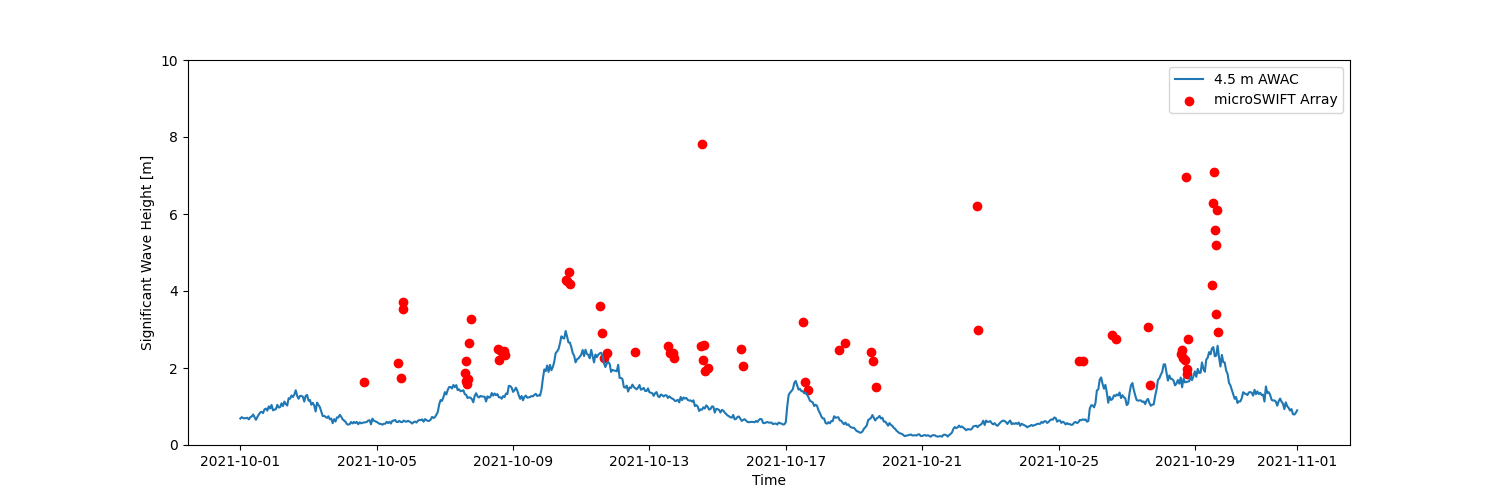

: 

: 

In [ ]:
# Plot Hs as a function of time and compare to AWAC for further verification
awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
awac_time = cftime.num2pydate(awac_data['time'], units=awac_data['time'].units, calendar=awac_data['time'].calendar)
fig_hs, ax = plt.subplots(figsize=(15,5))
ax.scatter(mission_time_all, Hs_all, color='r', label='microSWIFT Array')
ax.plot(awac_time, awac_data['waveHs'][:], label='4.5 m AWAC')
ax.set_ylim(0,10)
ax.set_xlabel('Time')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()
fig_hs.savefig('./Figures/Hs_timeseries.png')

['../microSWIFT_data/cleanedDataset/mission_78.nc', '../microSWIFT_data/cleanedDataset/mission_39.nc', '../microSWIFT_data/cleanedDataset/mission_68.nc', '../microSWIFT_data/cleanedDataset/mission_19.nc', '../microSWIFT_data/cleanedDataset/mission_58.nc', '../microSWIFT_data/cleanedDataset/mission_18.nc', '../microSWIFT_data/cleanedDataset/mission_59.nc', '../microSWIFT_data/cleanedDataset/mission_79.nc', '../microSWIFT_data/cleanedDataset/mission_28.nc', '../microSWIFT_data/cleanedDataset/mission_8.nc', '../microSWIFT_data/cleanedDataset/mission_38.nc', '../microSWIFT_data/cleanedDataset/mission_69.nc', '../microSWIFT_data/cleanedDataset/mission_81.nc', '../microSWIFT_data/cleanedDataset/mission_72.nc', '../microSWIFT_data/cleanedDataset/mission_23.nc', '../microSWIFT_data/cleanedDataset/mission_17.nc', '../microSWIFT_data/cleanedDataset/mission_33.nc', '../microSWIFT_data/cleanedDataset/mission_13.nc', '../microSWIFT_data/cleanedDataset/mission_27.nc', '../microSWIFT_data/cleanedData

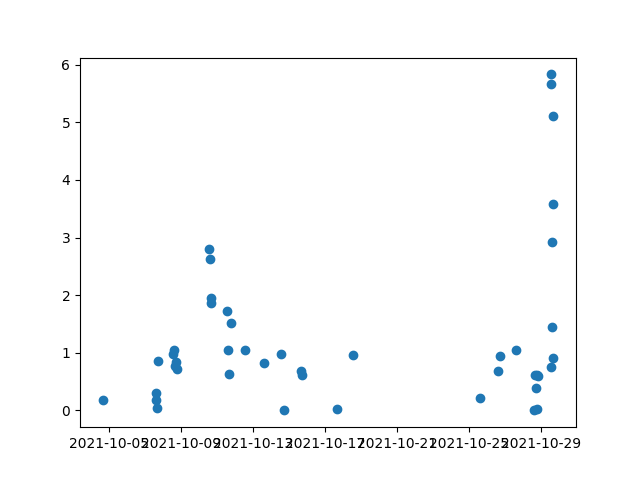

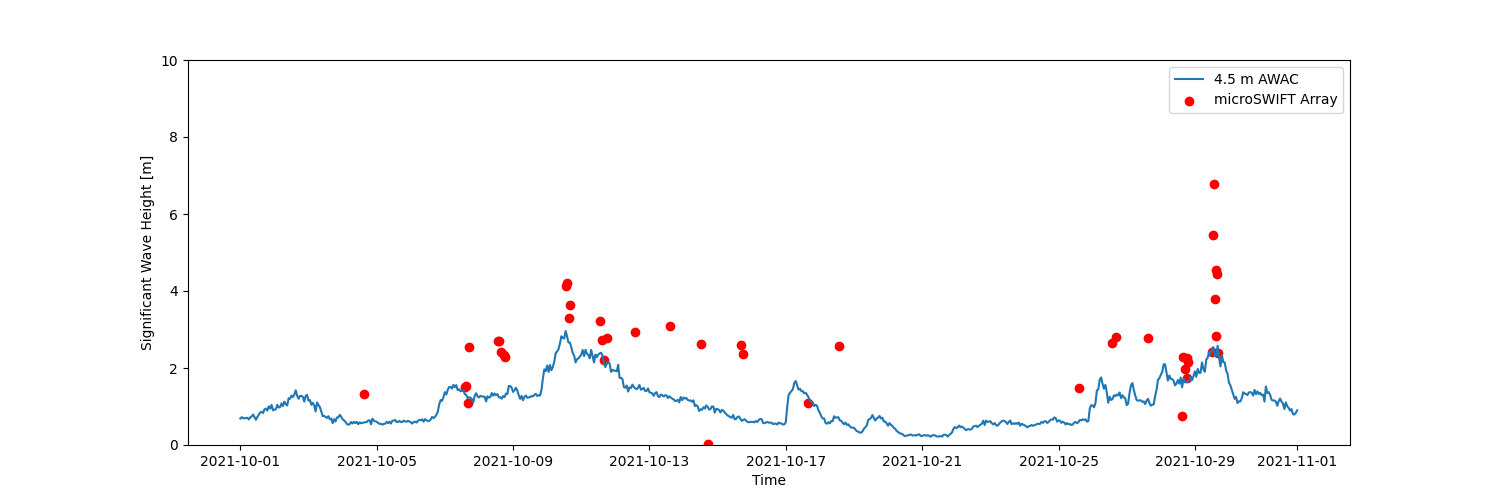

: 

: 

In [ ]:
# Compute significant wave height from wave in the 4-5 m zone
Hs_45 = []
waves_var_45 = []
for waves in wave_heights_45:
    Hs_45.append(computeSigWaveHeight(waves))
    waves_var_45.append(np.var(waves))

print(mission_nums_45)
fig, ax = plt.subplots()
ax.scatter(mission_time_45, waves_var_45)

# Plot Hs as a function of time and compare to AWAC for further verification
awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
awac_time = cftime.num2pydate(awac_data['time'], units=awac_data['time'].units, calendar=awac_data['time'].calendar)
fig_hs, ax = plt.subplots(figsize=(15,5))
ax.scatter(mission_time_45, Hs_45, color='r', label='microSWIFT Array')
ax.plot(awac_time, awac_data['waveHs'][:], label='4.5 m AWAC')
ax.set_ylim(0,10)
ax.set_xlabel('Time')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()


: 

: 

: 

: 